# Permodelan Cluster 3

Import segala pustaka (library) yang digunakan

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

## Pembacaan Data

Baca dataset train

In [2]:
data=pd.read_excel('../dataset_new.xlsx',sheet_name='train')
data

,KodeBarang,1,2,3,4,5,6,7,8,9,...,46,47,48,49,50,51,52,53,54,cluster
0,04121,7,9,6,9,40,0,3,0,7,...,67,77,11,57,43,50,37,21,136,0
1,18031,230,227,279,153,190,256,267,305,238,...,336,153,103,221,360,280,240,120,548,1
2,04161,102,50,45,41,71,11,52,14,66,...,21,20,7,33,21,28,30,10,18,0
3,04162,272,155,214,226,268,110,204,253,193,...,102,118,120,211,292,105,108,101,117,1
4,04163,28,28,29,52,44,21,47,15,24,...,18,23,22,16,22,31,36,17,14,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,04157,55,64,44,61,30,1,24,37,67,...,20,10,300,34,7,7,6,4,21,0
102,18104,46,295,83,112,70,40,18,140,97,...,47,54,27,15,57,132,66,34,146,0
103,18106,200,204,0,2,10,7,0,27,74,...,15,136,15,15,14,131,84,12,14,0
104,18092,297,418,329,70,498,59,298,376,259,...,450,498,254,260,336,493,438,408,322,1


Baca dataset test

In [3]:
data_test = pd.read_excel('../dataset_new.xlsx',sheet_name='test')
data_test

,KodeBarang,bulan 1,bulan 2,bulan 3,bulan 4,bulan 5,bulan 6
0,04121,5,12,8,14,40,40
1,18031,573,340,441,270,488,240
2,04161,27,5,26,34,40,56
3,04162,162,82,72,98,126,120
4,04163,23,20,9,5,22,6
...,...,...,...,...,...,...,...
101,04157,138,14,12,21,25,10
102,18104,60,103,39,87,276,40
103,18106,16,7,65,24,13,27
104,18092,721,184,150,488,648,149


Hilangkan judul kolom agar tidak terbaca di deep learning
Pastikan cluster pada dataset sudah berupa angka

In [4]:
clusters=data['cluster']
data_test['cluster'] = clusters
# data_test.drop(['bulan 4','bulan 5','bulan 6'],axis=1,inplace=True)

In [5]:
data_test

,KodeBarang,bulan 1,bulan 2,bulan 3,bulan 4,bulan 5,bulan 6,cluster
0,04121,5,12,8,14,40,40,0
1,18031,573,340,441,270,488,240,1
2,04161,27,5,26,34,40,56,0
3,04162,162,82,72,98,126,120,1
4,04163,23,20,9,5,22,6,0
...,...,...,...,...,...,...,...,...
101,04157,138,14,12,21,25,10,0
102,18104,60,103,39,87,276,40,0
103,18106,16,7,65,24,13,27,0
104,18092,721,184,150,488,648,149,1


In [6]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

Make sure ada berapa cluster?

In [7]:
len(data['cluster'].unique())

4

Ambil jumlah produk dalam setiap Cluster

In [8]:
#now lets take clusters
c0 = data.query("cluster == 0")
print("Jumlah Produk:")
print(c0['KodeBarang'].size)
c1 = data.query("cluster == 1")
print("Jumlah Produk:")
print(c1['KodeBarang'].size)
c2 = data.query("cluster == 2")
print("Jumlah Produk:")
print(c2['KodeBarang'].size)
c3 = data.query("cluster == 3")
print("Jumlah Produk:")
print(c3['KodeBarang'].size)

Jumlah Produk:
70
Jumlah Produk:
31
Jumlah Produk:
4
Jumlah Produk:
1


In [9]:
c0_t = data_test.query("cluster == 0")
print("Jumlah Produk:")
print(c0['KodeBarang'].size)
c1_t = data_test.query("cluster == 1")
print("Jumlah Produk:")
print(c1['KodeBarang'].size)
c2_t = data_test.query("cluster == 2")
print("Jumlah Produk:")
print(c2['KodeBarang'].size)
c3_t = data_test.query("cluster == 3")
print("Jumlah Produk:")
print(c3['KodeBarang'].size)

Jumlah Produk:
70
Jumlah Produk:
31
Jumlah Produk:
4
Jumlah Produk:
1


## Pembuatan model cluster 3

Buat fungsi bikin `windowed dataset` jadi si data di couple in sama waktu (timeframe)

In [10]:
#oke ada ternyata yang cuman sendirian (1 product di cluster tersebut), kita beresin dia dulu, the easiest, dan biar keliatan kita
#ngapain aja di time series ini
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
# ini fungsinya buat nge ubah dataset jadi windowed

In [11]:
#next kita ubah bentuk data nya dari yang tadinya kesamping jadi ke bawah, tapi pertama mau aku drop dulu cluster sama kode produknya
c3=c3.drop(columns=['KodeBarang','cluster'])
c3_t = c3_t.drop(columns=['KodeBarang','cluster'])

Plot per produk cluster 3

<AxesSubplot:>

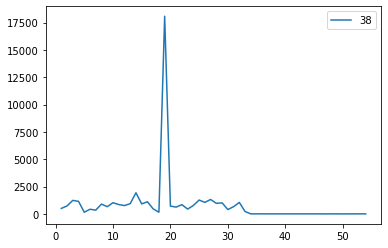

In [12]:
c3.T.plot()

In [13]:
#next, buat dia kayak mejeneng time series seperti biasanya, which is datanya ke bawah, 
new_c3=[]
time=[]
for idx,_ in enumerate(c3):
    new_c3.append(c3.iloc[0,idx])
    time.append(idx)
print(time,new_c3)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53] [497, 725, 1233, 1145, 149, 422, 341, 893, 655, 1022, 851, 758, 933, 1928, 912, 1106, 452, 151, 18079, 714, 617, 843, 436, 769, 1264, 1049, 1317, 962, 1008, 394, 659, 1046, 213, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -5, 0, 0, -5, 0, 0, 0, 0]


In [14]:
#sama aja cuman data test
new_c3_t=[]
time_t=[]
i = 55
for idx,a in enumerate(c3_t):
    new_c3_t.append(c3_t[a].mean())
    time_t.append(i)
    i+=1

In [15]:
new_c3_t

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [16]:
#normalisasi, karena gap nya ada yang sampe ribuan, biar lebih gampang tugas ann nya
series=new_c3
min = np.min(series)
max = np.max(series)
series = series - min
series = series / (max-min)

# scaler = MinMaxScaler(feature_range=(0, 1))
# series = scaler.fit_transform(series)

time = np.array(time)

In [17]:
# Karena data test tidak ada gap nya, maka kita tidak perlu normalisasi
series_t=new_c3_t

time_t = np.array(time_t)

In [18]:
series_t

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [19]:
split_time = 3 # ini berapa bulan terkahir yang mau di potong buat pengujian?

time_train = time
x_train =  series
time_valid =  time_t
x_valid =  series_t

In [20]:
x_valid

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [21]:
#buat data biar dibagi per window, jadi me masang masangkan waktu dan value,
window_size = 2
batch_size = 2
shuffle_buffer_size = 10

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
valid_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

In [22]:
train_set

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>

In [23]:
valid_set

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float32, tf.float32)>

Penyusunan deep learning nya

Kita Menggunakan BLSTM atau *Bidirectional Long Short Term Memory*. BLSTM adalah proses pembuatan jaringan syaraf tiruan untuk memiliki urutan informasi dalam kedua arah mundur (masa depan ke masa lalu) atau maju (masa lalu ke masa depan).

kalo ini pake BLSTM dengan input layer sebanyak 2 neuron, BLSTM layer ada dua, yang pertama ada 64 neuron, terus yang kedua ada 32 neuron, dibuat mengkerucut (segitiga terbalik) seolah kita menyederhanakan data datanya, jadi kan makin dalem makin sedikit tuh, karena ada yang ga kepake kepake buat menentukan sales nya dan lain lain, 

terus setiap selesai masuk BLSTM layer, ada dropout, itu tuh untuk mengeliminasi secara random (di case ini 50%) sambungan antara neuron, dan nge "matiin" neuronnya itu juga, mensimulasi degradasi neuron dan sambungannya saat kita tidur, alias proses mengubah ingatan jadi jangka menengah ke panjang dari apa yang kita dapatkan pada hari itu. 

In [24]:
model = tf.keras.Sequential([
        tf.keras.layers.Dense(2, input_shape=[None, 1]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        
        # tf.keras.layers.Flatten(),
        # tf.keras.layers.Dense(1024, activation='relu'),
        # tf.keras.layers.Dropout(0.5),
        # tf.keras.layers.Dense(512, activation='relu',kernel_regularizer=tf.keras.regularizers.l1(l1=0.01)),
        # tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01)),
        # tf.keras.layers.Dense(32, activation='relu'),
        # tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='relu')
    ])

    #the blstm part

In [25]:
#Using mae and mse
#model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),metrics=['mae'],loss='mse')
model.compile(optimizer=tf.keras.optimizers.Adam(),metrics=['mae'],loss='mse')
model.summary()
hist=model.fit(train_set,epochs=150,validation_data=valid_set, batch_size=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, None, 2)           4         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         34304     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 75,589
Trainable params: 75,589
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
26/26 [==============================] - 7s 56ms/step - loss: 0.0191 - mae: 0.0576 - val_loss: 0.0015 - val_mae: 0.0388
Epoch 2/150
26/26 [==============================] - 0s 5ms/step - loss: 0.0173 - mae: 0.0438 - val_loss: 6.6829e-04 -

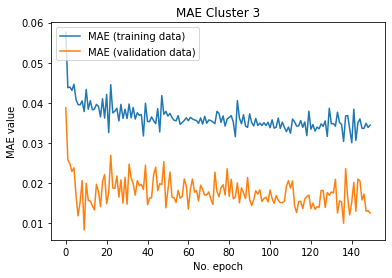

In [26]:
import matplotlib.pyplot as plt

plt.plot(hist.history['mae'], label='MAE (training data)')
plt.plot(hist.history['val_mae'], label='MAE (validation data)')

plt.title('MAE Cluster 3')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

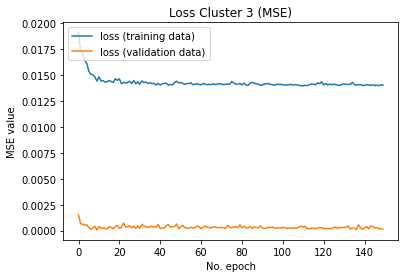

In [27]:
plt.plot(hist.history['loss'], label='loss (training data)')
plt.plot(hist.history['val_loss'], label='loss (validation data)')

plt.title("Loss Cluster 3 (MSE)")
plt.ylabel('MSE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [28]:
prediksi=model.predict(np.array(x_valid))
prediksi

array([[0.01534984],
       [0.01534984],
       [0.01534984],
       [0.01534984],
       [0.01534984],
       [0.01534984]], dtype=float32)

In [29]:
prediksi=prediksi.flatten()

In [30]:
hasil=np.concatenate((series,prediksi))

In [31]:
hasil.shape

(60,)

In [32]:
asli = np.concatenate((series,series_t))


In [33]:
hasil = hasil * (max-min) + min
asli = asli * (max-min) + min

[]

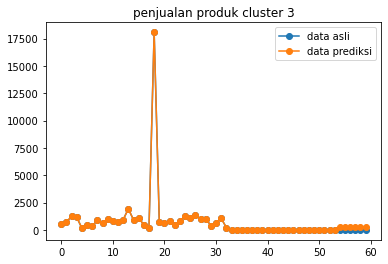

In [34]:
plt.plot(asli,marker = 'o',label='data asli')
plt.plot(hasil,marker = 'o',label='data prediksi')
plt.title('penjualan produk cluster 3')
plt.legend()
plt.plot()

In [35]:
model.save('cluster3_newdata.h5')